<a href="https://colab.research.google.com/github/Gjeffroy/labelling_data_with_llm/blob/main/label_data_with_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Label data with LLM

In this notebook, I will explore how to extract labels from text using a generative AI model. This approach offers the primary advantage of efficiently training a classification model, such as a Convolutional Neural Network (CNN), which can then perform inference on new data with significantly lower computational costs than an LLM. This method enhances the scalability of processing large volumes of text data and facilitates the extraction of valuable statistics and insights.

In the first section, I will demonstrate the process of label extraction using a generative AI with the LangChain template and parser.

In the second section, I will explore ways to improve the consistency of the labels proposed by the model by grouping them into broader categories.


In [1]:
! pip install openai
! pip install langchain
! pip install pandas

## Add OpenAi APi key to colab Secret

To add a secret key to colab -> check this twit !

<blockquote class="twitter-tweet"><p lang="en" dir="ltr">You can now safely store your private keys, such as your <a href="https://twitter.com/huggingface?ref_src=twsrc%5Etfw">@huggingface</a> or <a href="https://twitter.com/kaggle?ref_src=twsrc%5Etfw">@kaggle</a> API tokens, in Colab! Values stored in Secrets are private, visible only to you and the notebooks you select. <a href="https://t.co/dz9noetUAL">pic.twitter.com/dz9noetUAL</a></p>&mdash; Colaboratory (@GoogleColab) <a href="https://twitter.com/GoogleColab/status/1719798406195867814?ref_src=twsrc%5Etfw">November 1, 2023</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

In [2]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('openai_API_key')

## Load Libraries and data

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain
import pandas as pd

Place the bfro_locations.csv in the sample data folder.
The data are available here :

In [4]:
data = pd.read_csv("./sample_data/bfro_locations.csv")
print(len(data))
data.title.head()

4309


0    Report 637: Campers' encounter just after dark...
1    Report 2917: Family observes large biped from car
2    Report 7963: Sasquatch walks past window of ho...
3    Report 9317: Driver on Alcan Highway has noon,...
4    Report 13038: Snowmobiler has encounter in dee...
Name: title, dtype: object

## Labeling process

In [5]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

### Defining the labels
Here we define the labels to extract. Feel free to add some of your own by providing a short and accurate description. The rest of the notebook will automatically adapt to accommodate them.

In [6]:
label_descriptions = [
        {'name': "time",
        'description': "Encounter occuring at nighttime or daytime \
                  Possible values to return : nighttime, daytime\
                  If this information is not found, output NA."},
        {'name': "profil",
        'description': "profil of the individual(s)\
                      Example of possible values to return : biker, driver, hiker, etc.. \
                      If this information is not found, output NA."},
        {'name': "location_type",
        'description': "the type of location \
                      Example of possible values to return : road, house, nature, etc.. \
                      If this information is not found, output NA."},
         {'name': "encounter_type",
        'description': "if bigfoot as been heard or sighted \
                      Possible values to return : heard, sighted, encounter \
                      If this information is not found, output NA."}

]

In [7]:
# creating a string by stacking the label description to be part of the prompt
label_descriptions_str = ""
for description in label_descriptions:
  label_descriptions_str += description['name'] + ": "
  label_descriptions_str += description['description']
  label_descriptions_str += "\n\n"


# creating response schemas to parse the output
response_schemas = []
for description in label_descriptions:
  response_schema = ResponseSchema(name=description['name'],
                 description=description['description'])
  response_schemas.append(response_schema)

output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
format_instructions = output_parser.get_format_instructions()

In [8]:
format_instructions

'The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":\n\n```json\n{\n\t"time": string  // Encounter occuring at nighttime or daytime                   Possible values to return : nighttime, daytime                  If this information is not found, output NA.\n\t"profil": string  // profil of the individual(s)                      Example of possible values to return : biker, driver, hiker, etc..                       If this information is not found, output NA.\n\t"location_type": string  // the type of location                       Example of possible values to return : road, house, nature, etc..                       If this information is not found, output NA.\n\t"encounter_type": string  // if bigfoot as been heard or sighted                       Possible values to return : heard, sighted, encounter                       If this information is not found, output NA.\n}\n```'

### Create the prompt template
The prompt template takes two inputs : report and format instruction

In [9]:
labelling_template = f"""\

The following report is about BigFoot sighting.
For the following text, extract the following information: \

{label_descriptions_str}


""" + """Values should always be lower cap !!

report : {report}.

{format_instructions}"""

prompt = ChatPromptTemplate.from_template(template=labelling_template)

### Initialising an LLM instance
Temperature is set to 0 to make the response more consistent

In [10]:
chat = ChatOpenAI(temperature=0.0)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


### Data Labelling
Data labelling by iterating over the row of the dataframe and

In [11]:
labels = []
data_sub = data[:30]
for index, row in data_sub.iterrows():
    # Run the chain
    messages = prompt.format_messages(report=row['title'],
                                      format_instructions=format_instructions)
    response = chat(messages)
    output_dict = output_parser.parse(response.content)
    labels.append(output_dict)

df_results = pd.DataFrame.from_dict(labels)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


## Visualise the results

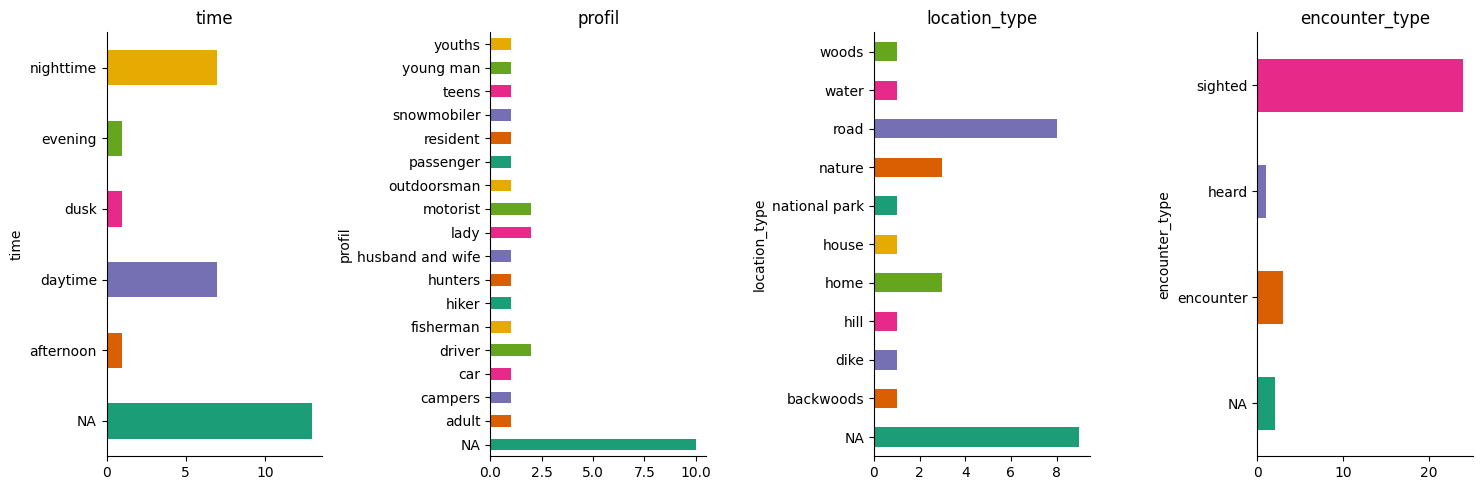

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, df_results.shape[1], figsize=(15, 5))
for i, col in enumerate(df_results.columns):

  df_results.groupby(col).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[i])
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_title(col)

plt.tight_layout()
plt.show()

## Check NA label

In [13]:
import random

def find_null_indices(df):
    # Dictionary to store the result
    null_indices = {}

    # Iterate over the DataFrame by row
    for index, row in df.iterrows():
        # List to store columns with null values for the current row
        null_columns = row[row.isin(['NA'])].index.tolist()
        if null_columns:
            null_indices[index] = null_columns

    return null_indices

# checking the first 20 examples
all_indices_with_NA = find_null_indices(df_results)
subset_indices = random.sample(list(all_indices_with_NA.keys()), 20)
subset_indices = {k: all_indices_with_NA[k] for k in subset_indices}
for idx, col_with_NA in subset_indices.items():
  print(data[data.index==idx].title.values, col_with_NA)


['Report 7235: Recollection of an afternoon sighting on Green Mountain'] ['profil', 'location_type']
['Report 4743: Nighttime sighting by two teens in southern Conecuh County'] ['location_type']
['Report 1907: Motorist sees Bigfoot like creature, hears scream'] ['time', 'location_type']
['Report 8679: Adult recalls childhood sighting at dusk near Moody'] ['location_type']
['Report 451: Young man has sighting near home'] ['time']
['Report 245: Two outdoorsman fishing, loud vocalizations, footsteps heard'] ['time', 'location_type']
['Report 7963: Sasquatch walks past window of house at night'] ['profil']
['Report 8171: Nighttime Sighting on County Road'] ['profil']
['Report 13038: Snowmobiler has encounter in deep snow near Potter, AK'] ['time']
['Report 6938: Tracks and feces found in freshly turned field'] ['time', 'profil', 'location_type', 'encounter_type']
['Report 832: Witnesses spot a tall, brown object moving on a hill, also reported are moans and a sighting where red eyes are de

Upon reviewing random examples, it appears that NA is only returned when the information is not found within the text. Good !

# Feature engineering
Let's make the labels more consistent by grouping them into broader cateogies

In [14]:
print(df_results['time'].unique())
print(df_results['profil'].unique())
print(df_results['location_type'].unique())

['nighttime' 'NA' 'daytime' 'evening' 'afternoon' 'dusk']
['campers' 'car' 'NA' 'driver' 'snowmobiler' 'passenger' 'outdoorsman'
 'resident' 'husband and wife' 'young man' 'fisherman' 'motorist'
 'hunters' 'lady' 'teens' 'youths' 'adult' 'hiker']
['national park' 'road' 'house' 'nature' 'NA' 'home' 'water' 'hill'
 'woods' 'dike' 'backwoods']


### Method 1 : reassigning labels by hand

In [17]:
def replace_values(df, column, values_to_replace, replacement):
    """
    Replace multiple values with a single replacement value in a specified column of a pandas DataFrame.

    Parameters:
        df (DataFrame): The pandas DataFrame.
        column (str): The name of the column in which values are to be replaced.
        values_to_replace (list): A list of values to be replaced.
        replacement (str): The value to replace the specified values.

    Returns:
        DataFrame: The DataFrame with replaced values.
    """
    for value in values_to_replace:
        df[column] = df[column].replace(value, replacement)
    return df

df_results_relabeled = df_results.copy()

# time
df_results_relabeled = replace_values(df_results_relabeled, 'time', ['late afternoon', 'early morning', 'afternoon'], 'daytime')
df_results_relabeled = replace_values(df_results_relabeled, 'time', ['evening', 'dusk'], 'nighttime')

# profil
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['boys','teens', 'youths', 'teenager','youngster', 'young man'], 'underage')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['lady', 'man'], 'adult')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['squirrel hunter', 'duck hunter', 'bow hunter', 'deer hunter', 'coon hunter', 'hunters'], 'hunter')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['atv rider', 'motorists', 'biker','motorist', 'snowmobiler'], 'rider')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['husband and wife'], 'couple')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['bus driver'], 'driver')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['hiker', 'kayaker', 'campers', 'spelunker'], 'outdoorsman')
df_results_relabeled = replace_values(df_results_relabeled, 'profil', ['fisherman'], 'fisher')

# profil
df_results_relabeled = replace_values(df_results_relabeled, 'location_type', ['water', 'hill', 'woods', 'mountain', 'backwoods', 'swamp',  'outside','forest',  'wooded area', 'river' ], 'nature')
df_results_relabeled = replace_values(df_results_relabeled, 'location_type', ['car', 'road','bridge', 'highway'], 'road')
df_results_relabeled = replace_values(df_results_relabeled, 'location_type', ['field', 'farm' ], 'farm area')
df_results_relabeled = replace_values(df_results_relabeled, 'location_type', ['hotel','school'] , 'public building')
df_results_relabeled = replace_values(df_results_relabeled, 'location_type', ['house','home', 'private property', 'backyard'] , 'home')

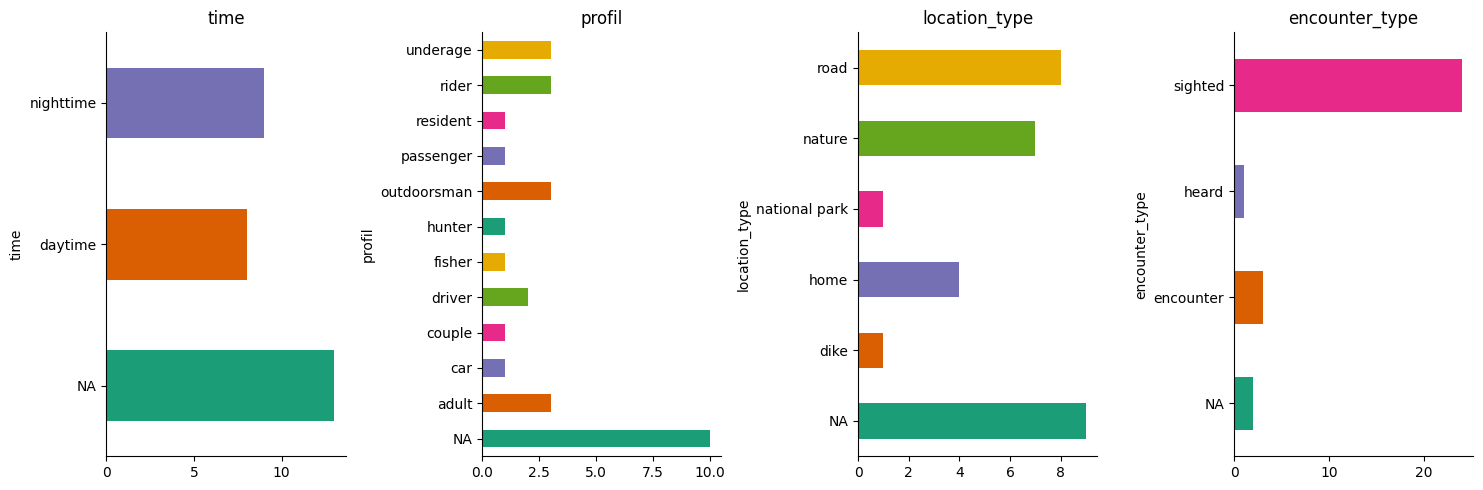

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, df_results.shape[1], figsize=(15, 5))
for i, col in enumerate(df_results.columns):

  df_results_relabeled.groupby(col).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[i])
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_title(col)

plt.tight_layout()
plt.show()

Labeling by hand gives more control but sounds a bit tedious and less scalable. New labels will have to be assigned by hand to categories.

### Method 2: Let an LLM sort the labels into broader categories

In order to be more scalable, let's look at automating this task with an LLM.

In [19]:
chat = ChatOpenAI(temperature=0.0)

In [20]:
categories__by_column = {
  'profil':['hunter', 'underage',  'adult', 'rider', 'driver', 'outdoorsman'],
  'time' :['daytime', 'nighttime'],
  'location_type': ['nature', 'road infrastructure and vehicules',  'farm and fields', 'public building', 'private property']
}
column = 'location_type'


### Writing the prompt

In [21]:
def create_ouput_parser(categories):
  # creating response schemas to parse the output
  response_schemas_cat = []
  for category in categories:
    if category != 'other':
      response_schema = ResponseSchema(name=category,
                  description= "list of values that fits in this category" )
    else :
      response_schema = ResponseSchema(name=category,
                  description= "List of values that fits nowhere else." )
    response_schemas_cat.append(response_schema)

  output_parser = StructuredOutputParser.from_response_schemas(response_schemas_cat)

  return output_parser


  format_instructions = output_parser.get_format_instructions()

def create_template(values, categories, format_instruction):
  labelling_template = """\
  Sort the values in into the broader categories \
  List of values to sort : {values}
  categories : {categories}

  Rules :
  - A value must be assigned to a single category.
  - A value cannot be placed in two or more categories.
  - All values most be assign

  {format_instructions}
  """

  prompt = ChatPromptTemplate.from_template(template=labelling_template)

  return prompt

### Assigning labels to the broader categories

In [22]:
new_label_dict = {}
for column in categories__by_column:
  categories = categories__by_column[column]
  values =  df_results[column].unique()
  output_parser = create_ouput_parser(categories)
  format_instruction = output_parser.get_format_instructions()
  prompt = create_template(values, categories, format_instruction)
  messages = prompt.format_messages(values = values,
                                    categories = categories,
                                    format_instructions = format_instruction)
  response = chat(messages)
  output_dict = output_parser.parse(response.content)
  print(output_dict)
  new_label_dict[column] = output_dict

{'hunter': ['hunters', 'fisherman'], 'underage': ['teens', 'youths'], 'adult': ['resident', 'husband and wife', 'adult'], 'rider': ['campers', 'snowmobiler', 'passenger'], 'driver': ['car', 'motorist'], 'outdoorsman': ['outdoorsman', 'hiker']}
{'daytime': ['daytime', 'afternoon'], 'nighttime': ['nighttime', 'evening', 'dusk']}
{'nature': ['national park', 'nature', 'water', 'hill', 'woods', 'backwoods'], 'road infrastructure and vehicules': ['road'], 'farm and fields': [], 'public building': ['house'], 'private property': ['home', 'dike']}


In [23]:
def replace_values_with_dict(df, column, replacements_dict):
    """
    Replace values in a DataFrame column based on a dictionary.

    Parameters:
        df (DataFrame): The pandas DataFrame.
        column (str): The name of the column in which values are to be replaced.
        replacements_dict (dict): A dictionary where keys are the replacement values
                                  and values are lists of values to be replaced.

    Returns:
        DataFrame: The DataFrame with replaced values.
    """
    # Flatten the dictionary to create a reverse mapping
    reverse_mapping = {item: key for key, values in replacements_dict.items() for item in values}

    # Replace the values in the specified column based on the reverse mapping
    df[column] = df[column].replace(reverse_mapping)

    return df

df_results_relabeled_by_IA = df_results.copy()
for column in categories__by_column:
  output_dict = new_label_dict[column]
  df_results_relabeled_by_IA = replace_values_with_dict(df_results_relabeled_by_IA, column, output_dict)

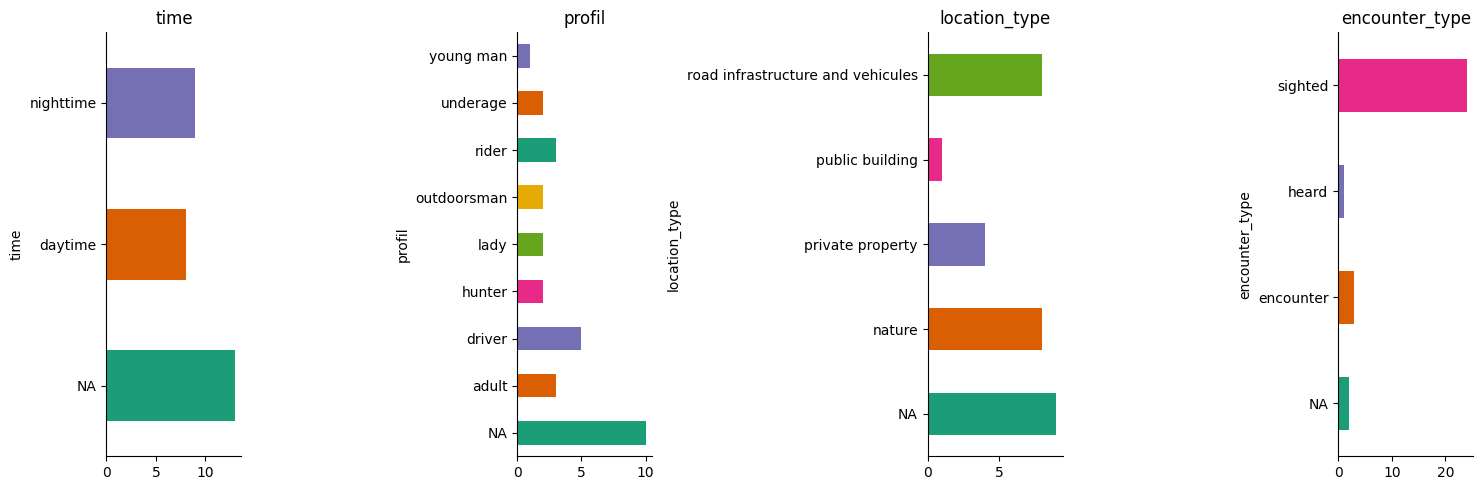

In [24]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, df_results.shape[1], figsize=(15, 5))
for i, col in enumerate(df_results_relabeled_by_IA.columns):

  df_results_relabeled_by_IA.groupby(col).size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'), ax=axes[i])
  axes[i].spines[['top', 'right']].set_visible(False)
  axes[i].set_title(col)

plt.tight_layout()
plt.show()